In [62]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join, exists
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, interactive, Dropdown
from tensorflow.distributions import Normal
from keras.layers import Dense, Input, Layer, Concatenate, Activation
from keras.models import Model
import keras.backend as K
from sklearn.preprocessing import StandardScaler

In [4]:
ls /glade/p/ral/nsap/rozoff/hfip/

ascii/                 realtime/       reforecast/
besttrack_predictors/  realtime_mslp/  reforecast_mslp/


In [5]:
best_track_path = "/glade/p/ral/nsap/rozoff/hfip/besttrack_predictors/"
atl_best_track = xr.open_dataset(join(best_track_path, "diag_2015_2017_adecks_atl_bug_corrected.nc"))
atl_best_track["vmax_bt_newer"] = xr.DataArray(atl_best_track["vmax_bt_new"], dims=("time", "run"))

In [112]:
atl_best_track["vmax_bt_newer"]

<xarray.DataArray 'vmax_bt_newer' (time: 43, run: 1146)>
array([[30. , 35. , 40. , ..., 45. , 40. , 40. ],
       [32.5, 37.5, 40. , ..., 42.5, 40. ,  nan],
       [35. , 40. , 40. , ..., 40. , 40. ,  nan],
       ...,
       [30. , 25. , 25. , ...,  nan,  nan,  nan],
       [27.5, 25. , 25. , ...,  nan,  nan,  nan],
       [25. , 25. , 25. , ...,  nan,  nan,  nan]])
Dimensions without coordinates: time, run
Attributes:
    long_name:  New BT VMAX
    units:      kt

In [7]:
atl_best_track

<xarray.Dataset>
Dimensions:                 (TC quadrants: 4, nrun: 1146, run: 1146, time: 43)
Dimensions without coordinates: TC quadrants, nrun, run, time
Data variables:
    DATE                    (run) |S10 ...
    STNAM                   (run) |S10 ...
    STNUM                   (run) |S2 ...
    BASIN                   (run) |S2 ...
    TIME                    (time) int32 ...
    LAT                     (time, run) float32 ...
    LON                     (time, run) float32 ...
    VMAX                    (time, run) float32 ...
    RMW                     (time, run) float32 ...
    MIN_SLP                 (time, run) float32 ...
    SHR_MAG                 (time, run) float32 ...
    SHR_HDG                 (time, run) float32 ...
    STM_SPD                 (time, run) float32 ...
    STM_HDG                 (time, run) float32 ...
    SST                     (time, run) float32 ...
    TPW                     (time, run) float32 ...
    LAND                    (time, run)

In [9]:
bt_vars = pd.Series(list(atl_best_track.variables.keys()))
m_vars = bt_vars[0:69]
for var in m_vars:
    print("{0:10s} {1:50s} {2:15s}".format(var, atl_best_track[var].attrs["long_name"], atl_best_track[var].attrs["units"]))

DATE       Forecast Run                                       YYYYMMDDHH     
STNAM      Storm Name                                         Name           
STNUM      Storm Number                                       number         
BASIN      Basin ID                                           Basin ID       
TIME       Forecast_Time                                      h              
LAT        Latitude                                           Deg N          
LON        Longitude                                          Deg E          
VMAX       Maximum_Wind_Speed                                 kt             
RMW        Radius_Maximum_Wind                                km             
MIN_SLP    Min_Sea_Lev_Pres                                   hPa            
SHR_MAG    Shear_Magnitude                                    kt             
SHR_HDG    Shear_Heading                                      Deg            
STM_SPD    Storm_Speed                                        kt

In [10]:
bt_frame = atl_best_track[m_vars.tolist() + ["vmax_bt_newer"]].to_dataframe()

In [11]:
bt_frame["YEAR"] = bt_frame["DATE"].str[:4].astype(int)
bt_frame["valid_date"] = pd.DatetimeIndex(bt_frame["DATE"].str.decode("UTF-8") + "00") + pd.TimedeltaIndex(bt_frame["TIME"].values, unit="h")

In [22]:
bt_frame_small["vmax_bt_newer"].max()

155.0

In [14]:
bt_frame_small = bt_frame.dropna()

In [15]:
bt_frame_small.shape

(27425, 72)

In [135]:
class NormOut(Layer):
    def __init__(self, **kwargs):
        super(NormOut, self).__init__(**kwargs)
        self.mean_dense = Dense(1)
        self.sd_dense = Dense(1, activation=K.tf.exp)
        
    def call(self, inputs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        return Concatenate()([mean_x, sd_x])

    
def crps(y_true, y_pred, cdf_points=np.arange(0.0, 200.0, 5.0)):
    cdf_points_tensor = K.tf.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.tf.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    y_pred_cdf = Normal(loc=y_pred[:,0:1], scale=y_pred[:,1:2]).cdf(cdf_points_tensor)
    y_true_cdf = K.tf.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.tf.reduce_mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.tf.reduce_mean(cdf_diffs)

In [44]:
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = K.tf.Session(config=config)
K.set_session(sess)
sess.run(Normal(loc=K.tf.constant(np.array([[0.0], [1.0]]), dtype="float32"), 
                scale=K.tf.constant(np.array([[2.0], [3.0]]), dtype="float32")).cdf(K.tf.constant(np.arange(-2.0, 2.0, 0.1), dtype="float32")))
sess.run(K.tf.cast(K.tf.constant(np.random.normal(loc=50, scale=30, size=(100, 1)), dtype="float32") < 
                    K.tf.constant(np.arange(20.0, 70.0, 5), dtype="float32"), "float32"))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 

In [136]:
sess.run(crps(K.tf.constant(np.array([[70.0], [55.0]]), dtype="float32"), K.tf.constant(np.array([[75.0, 5], [50.0, 10]]), dtype="float32")))

0.07887024

In [137]:
input_vars = m_vars[4:34]
print(input_vars)
mod_in = Input((input_vars.size, ))
mod_dense_1 = Dense(50, activation="relu")(mod_in)
mod_dense_2 = Dense(50, activation="relu")(mod_dense_1)
mod_dense_3 = Dense(50, activation="relu")(mod_dense_2)
mod_out = NormOut()(mod_dense_3)
h_mod = Model(mod_in, mod_out)
h_mod.compile(loss=crps, optimizer="adam")

4        TIME
5         LAT
6         LON
7        VMAX
8         RMW
9     MIN_SLP
10    SHR_MAG
11    SHR_HDG
12    STM_SPD
13    STM_HDG
14        SST
15        TPW
16       LAND
17    TANG850
18    VORT850
19    DVRG200
20       RHLO
21       RHMD
22       RHHI
23      CAPE1
24      CAPE2
25      CAPE3
26     LHTFL1
27     LHTFL2
28     LHTFL3
29     SHTFL1
30     SHTFL2
31     SHTFL3
32    VMAXMPI
33     POTMPI
dtype: object


In [138]:
scaler = StandardScaler()
scaled_input = scaler.fit_transform(bt_frame_small[input_vars])
h_mod.fit(scaled_input, bt_frame_small["vmax_bt_newer"], epochs=30, batch_size=256)

Epoch 1/30
27425/27425 [==============================] - 1s 21us/step - loss: 1.0170
Epoch 2/30
27425/27425 [==============================] - 0s 11us/step - loss: 0.7005
Epoch 3/30
27425/27425 [==============================] - 0s 11us/step - loss: 0.4600
Epoch 4/30
27425/27425 [==============================] - 0s 12us/step - loss: 0.2023
Epoch 5/30
27425/27425 [==============================] - 0s 12us/step - loss: 0.1888
Epoch 6/30
27425/27425 [==============================] - 0s 11us/step - loss: 0.1804
Epoch 7/30
27425/27425 [==============================] - 0s 11us/step - loss: 0.1746
Epoch 8/30
27425/27425 [==============================] - 0s 11us/step - loss: 0.1696
Epoch 9/30
27425/27425 [==============================] - 0s 12us/step - loss: 0.1651
Epoch 10/30
27425/27425 [==============================] - 0s 12us/step - loss: 0.1607
Epoch 11/30
27425/27425 [==============================] - 0s 12us/step - loss: 0.1569
Epoch 12/30
27425/27425 [===========================

In [125]:
h_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               3100      
_________________________________________________________________
norm_out_5 (NormOut)         (None, 100)               0         
Total params: 3,100
Trainable params: 3,100
Non-trainable params: 0
_________________________________________________________________


In [139]:
h_preds = h_mod.predict(scaled_input)

In [145]:
variables = ["DATE", "STNAM", "STNUM", "BASIN", "TIME", "LAT", "LON", "VMAX"]
bt_frame = atl_best_track[variables].to_dataframe()


(array([3271., 5538., 4920., 4404., 3772., 3650., 4540., 6712., 5114.,
         685.]),
 array([  43.90999985,  139.51899986,  235.12799988,  330.73699989,
         426.34599991,  521.95499992,  617.56399994,  713.17299995,
         808.78199997,  904.39099998, 1000.        ]),
 <a list of 10 Patch objects>)

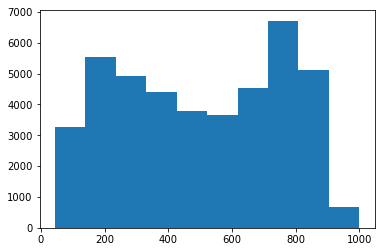

In [130]:
rmws = atl_best_track["INERTSYM1"].values.ravel()
plt.hist(rmws[~np.isnan(rmws)])

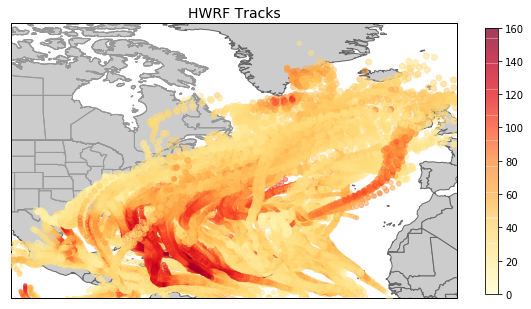

In [80]:
fig = plt.figure(figsize=(10, 7))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
#ax.coastlines(resolution="50m", color="red")
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="0.8", edgecolor="0.4")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="0.6")
ax.add_feature(countries)
ax.add_feature(states)
#ax.gridlines(draw_labels=True, )
ax.set_extent((-110, 0, 10, 70))
for run in atl_best_track.run:
    run_nans = np.isnan(atl_best_track["LON"][:, run])
    if np.any(run_nans):
        nan_start = np.where(run_nans)[0].min()
    else:
        nan_start = atl_best_track.dims["time"]
    if nan_start > 0:
        sc = ax.scatter(atl_best_track["LON"][:nan_start, run], 
                   atl_best_track["LAT"][:nan_start, run], np.sqrt(atl_best_track["RMW"][:nan_start, run]) * 3, 
                   atl_best_track["VMAX"][:nan_start, run], cmap="YlOrRd", vmin=0, vmax=160, zorder=3, alpha=0.5)
plt.title("HWRF Tracks", fontsize=14)
plt.colorbar(sc, shrink=0.7)
plt.savefig("hwrf_tracks.png", dpi=200, bbox_inches="tight")

In [78]:
lons

array([282.5, 282.4, 282.4, ...,   nan,   nan,   nan], dtype=float32)

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


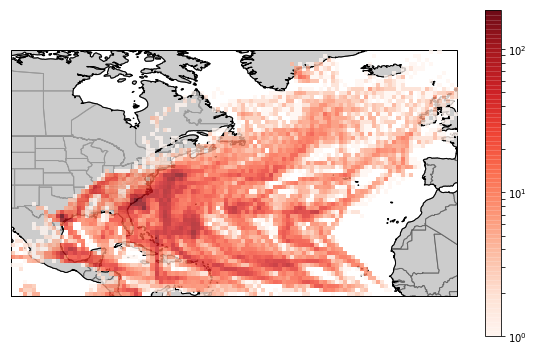

In [93]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
#ax.coastlines(resolution="50m", color="red")
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="0.8", edgecolor="0.4")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="0.6")
ax.add_feature(countries)
ax.add_feature(states)
ax.coastlines(resolution="50m")
#ax.gridlines(draw_labels=True, )
ax.set_extent((-110, 0, 10, 70))
lons = atl_best_track["LON"].values.ravel()
lats = atl_best_track["LAT"].values.ravel()
plt.hist2d(lons[~np.isnan(lons)] - 360, lats[~np.isnan(lats)], 
           bins=(np.arange(-110, 0, 1), np.arange(10, 70.5, 1)), cmap="Reds", cmin=1, norm=LogNorm(), zorder=3, alpha=0.8)
plt.colorbar()

In [95]:
np.count_nonzero(~np.isnan(lons))

42951

KeyError: 'vmax_bt_new'

In [113]:
def plot_runs(storm_name="harvey"):
    year = 2017
    plt.figure(figsize=(15, 8))
    bt_sub = bt_frame_small.loc[(bt_frame_small["YEAR"] == year) & (bt_frame_small["STNAM"].str.decode("UTF-8").str.strip() ==storm_name)]
    runs = bt_sub.index.get_level_values("run").unique()
    idx = pd.IndexSlice
    pred_frame = pd.DataFrame(h_preds, index=bt_frame_small.index)
    for run in runs[0:20]:
        plt.fill_between(pd.DatetimeIndex(bt_sub.loc[idx[run, :], "valid_date"]), pred_frame.loc[idx[run,:], 0] + pred_frame.loc[idx[run,:], 1], 
                         np.maximum(pred_frame.loc[idx[run,:], 0] - pred_frame.loc[idx[run,:], 1], 0), alpha=0.5)
        plt.plot(pd.DatetimeIndex(bt_sub.loc[idx[run, :], "valid_date"]), pd.DataFrame(h_preds, index=bt_frame_small.index).loc[idx[run,:], 0], marker='o')
    #plt.xlim(bt_sub["valid_date"].min(), bt_sub["valid_date"].max())
    plt.ylabel("Max Wind Speed (KT)", fontsize=14)
    plt.xlabel("Valid Date", fontsize=14)
    plt.title("Hurricane Harvey Neural Net Intensity Forecasts", fontsize=16)
    plt.savefig("harvey_nn_ts.png", dpi=200, bbox_inches="tight")


In [83]:
storm_names = bt_frame.loc[bt_frame["YEAR"] == 2017, "STNAM"].str.decode("utf-8").str.strip().unique().astype(str)

In [147]:
storm_names

array(['invest', 'two', 'bret', 'three', 'cindy', 'four', 'don', 'emily',
       'seven', 'franklin', 'eight', 'gert', 'nine', 'harvey', 'ten',
       'irma', 'jose', 'thirteen', 'katia', 'fourteen', 'lee', 'fifteen',
       'maria', 'sixteen', 'nate', 'seventeen', 'ophelia', 'eighteen',
       'philippe', 'nineteen', 'rina'], dtype='<U9')

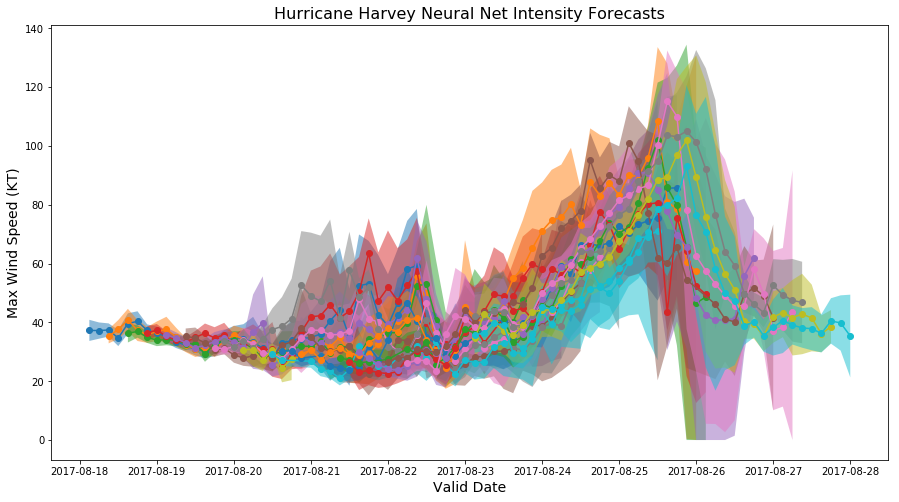

In [140]:
plot_runs()


/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


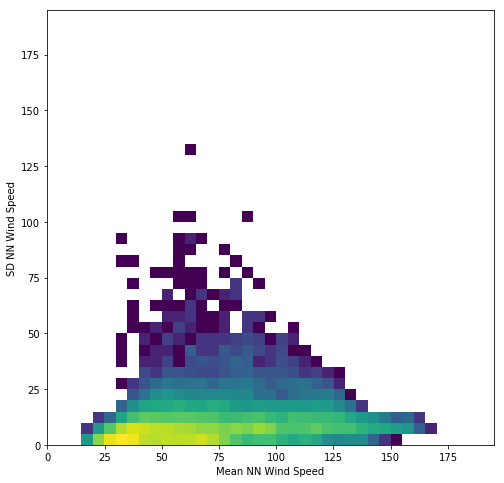

In [142]:
plt.figure(figsize=(8, 8))
plt.hist2d(h_preds[:, 0], h_preds[:, 1], cmin=1, bins=np.arange(0, 200, 5), norm=LogNorm())
plt.xlabel("Mean NN Wind Speed")
plt.ylabel("SD NN Wind Speed")
plt.savefig("hist.png", dpi=200, bbox_inches="tight")

(array([ 287., 2019., 3679., 3014., 2836., 2665., 2638., 2170., 1452.,
        1285., 1346.,  819.,  860.,  810.,  620.,  430.,  245.,  149.,
          87.,   14.]),
 array([ 15.64247036,  23.24362702,  30.84478369,  38.44594035,
         46.04709702,  53.64825368,  61.24941034,  68.85056701,
         76.45172367,  84.05288033,  91.654037  ,  99.25519366,
        106.85635033, 114.45750699, 122.05866365, 129.65982032,
        137.26097698, 144.86213365, 152.46329031, 160.06444697,
        167.66560364]),
 <a list of 20 Patch objects>)

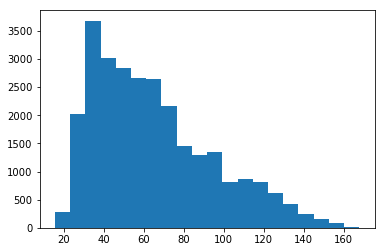

In [145]:
plt.hist(h_preds[:, 0], bins=20)

In [89]:
idx = pd.IndexSlice
year = 2017
storm_name = "harvey"
bt_sub = bt_frame.loc[(bt_frame_small["YEAR"] == year) & (bt_frame_small["STNAM"].str.decode("UTF-8").str.strip() ==storm_name)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [111]:
bt_sub.loc[idx[500, :], "VMAX"]

run  time
500  0       43.0
     1       40.0
     2       39.0
     3       37.0
     4       33.0
     5       35.0
     6       37.0
     7       35.0
     8       32.0
     9       29.0
     10      28.0
     11      30.0
     12      28.0
     13      29.0
     14      27.0
     15      34.0
     16      27.0
     17      34.0
     18      31.0
     19      29.0
     20      28.0
     21      31.0
     22      32.0
     23      30.0
     24      27.0
     25      29.0
     26      27.0
     27      25.0
     28      21.0
     29      18.0
     30      17.0
     31      18.0
     32      16.0
     33      12.0
     34      12.0
     35      14.0
     36      14.0
     37      12.0
     38      10.0
     39      11.0
     40       NaN
     41       NaN
     42       NaN
Name: VMAX, dtype: float32